In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
#from sessions import selected_009266, selected_008229, selected_009265, selected_57, selected_013829
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from itertools import combinations
from scipy.stats import ttest_rel

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [37]:
def pval2text(p_val):
    if p_val > 0.05:
        return 'n.s.'
    elif p_val > 0.01:
        return '*'
    elif p_val > 0.001:
        return '**'
    elif p_val > 0.0001:
        return '***'
    else:
        return '****'

In [4]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list

all_selected[:7], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10',
  '009266_hippoSIT_2023-04-19_10-33-51',
  '009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-21_08-43-00',
  '009266_hippoSIT_2023-04-21_13-12-31'],
 65)

## Collecting data

In [5]:
animals = list(set([session.split('_')[0] for session in all_selected]))

In [9]:
speed_thresh = 0.04  # m/s

EV_sil = np.zeros(0)
EV_bgr = np.zeros(0)
EV_tgt = np.zeros(0)
EV_sta = np.zeros(0)
EV_run = np.zeros(0)

SU_sil = np.zeros(0)
SU_bgr = np.zeros(0)
SU_tgt = np.zeros(0)
SU_sta = np.zeros(0)
SU_run = np.zeros(0)


for k, session in enumerate(all_selected):
    animal   = session.split('_')[0]
    session_path = os.path.join(source, animal, session)
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
    nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
    #bmap_file  = os.path.join(session_path, 'analysis', 'bMAP_segmentation.h5')
    meta_file  = os.path.join(session_path, 'meta.h5')
    desc_file  = os.path.join(session_path, 'descendants.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx = np.array(f['processed']['target_matrix'])
    with h5py.File(nmap_file, 'r') as f:
        fit = np.array(f['response_manifold'])
        unit_mx_ev = np.array(f['unit_mx_proc_ev'])
        unit_mx_su = np.array(f['unit_mx_proc_su'])

    #if os.path.exists(desc_file):
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    # else:
    #     speed = tl[:, 3]
    #     hd    = tl[:, 4]
    speed_ev = speed[sound_events[:, 2].astype(np.int32)]

#     with h5py.File(bmap_file, 'r') as f:
#         idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
#     idxs_bU_ev = np.array([x for x in range(len(sound_events)) if not x in idxs_tgt_succ_state_ev])
#     engaged_ev = np.zeros(len(sound_events))  # just engaged state 0/1, event sampling
#     engaged_ev[idxs_tgt_succ_state_ev] = 1

    unit_count = unit_mx_ev.shape[1]
    
    idxs_suc_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_suc_ev = np.array(idxs_suc_ev)

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed_ev < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed_ev > speed_thresh)[0]
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    #idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]
    #idxs_non_ev = np.where( (sound_events[:, 1] == 0) | (sound_events[:, 1] == 1) )[0]  # non-target

    # for behavioral state
    #idxs_non_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_non_ev)
    #idxs_non_sta_bE_ev = np.intersect1d(idxs_tgt_succ_state_ev, idxs_non_sta_ev)
    #idxs_non_sta_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_sta_ev)
    #idxs_sil_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_sil_ev)

    # for speed
    #idxs_non_run_ev    = np.intersect1d(idxs_run_ev, idxs_non_ev)
    #idxs_non_run_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_run_ev)
    #idxs_sil_bU_ev     = np.intersect1d(idxs_bU_ev, idxs_sil_ev)

    EV_sil = np.concatenate([EV_sil, fit[idxs_sil_ev][:, 0]])
    EV_bgr = np.concatenate([EV_bgr, fit[idxs_bgr_ev][:, 0]])
    EV_tgt = np.concatenate([EV_tgt, fit[idxs_tgt_ev][:, 0]])
    EV_sta = np.concatenate([EV_sta, fit[idxs_sta_ev][:, 0]])
    EV_run = np.concatenate([EV_run, fit[idxs_run_ev][:, 0]])
    SU_sil = np.concatenate([SU_sil, fit[idxs_sil_ev][:, 1]])
    SU_bgr = np.concatenate([SU_bgr, fit[idxs_bgr_ev][:, 1]])
    SU_tgt = np.concatenate([SU_tgt, fit[idxs_tgt_ev][:, 1]])
    SU_sta = np.concatenate([SU_sta, fit[idxs_sta_ev][:, 1]])  # black
    SU_run = np.concatenate([SU_run, fit[idxs_run_ev][:, 1]])
    
    print(f"Session {session} completed ({k} from {len(all_selected)})\r", end='')

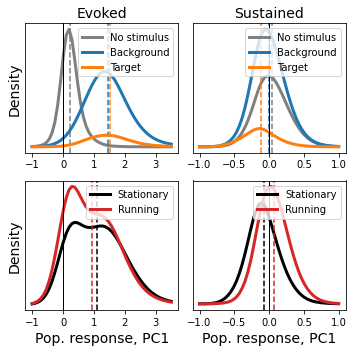

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

titles = ['Evoked', 'Sustained']
labels = ['No stimulus', 'Background', 'Target']
colors = ['grey', 'tab:blue', 'tab:orange']
x_spaces = [np.linspace(-1, 3.5, 50), np.linspace(-1, 1, 50)]

for j, resp_coll in enumerate([[EV_sil, EV_bgr, EV_tgt], [SU_sil, SU_bgr, SU_tgt]]):
    ax = axes[0][j]
    for i, responses in enumerate(resp_coll):
        # histogram - looks worse
        #ax.hist(responses, bins=np.linspace(-1, 3.5, 50), density=True)

        x_vals = x_spaces[j]
        ker_p = stats.gaussian_kde(responses, bw_method=0.35)
        ax.plot(x_vals, ker_p(x_vals)*len(responses), color=colors[i], lw=3, label=labels[i])
        ax.axvline(responses.mean(), color=colors[i], ls='--')

    ax.axvline(0, color='black', lw=1)   
    ax.legend(loc='upper right')
    ax.set_title(titles[j], fontsize=14)
    ax.set_yticks([])
    
colors = ['black', 'tab:red']
labels = ['Stationary', 'Running']
for j, resp_coll in enumerate([[EV_sta, EV_run], [SU_sta, SU_run]]):
    ax = axes[1][j]
    for i, responses in enumerate(resp_coll):
        # histogram - looks worse
        #ax.hist(responses, bins=np.linspace(-1, 3.5, 50), density=True)

        x_vals = x_spaces[j]
        ker_p = stats.gaussian_kde(responses, bw_method=0.35)
        ax.plot(x_vals, ker_p(x_vals)*len(responses), color=colors[i], lw=3, label=labels[i])
        ax.axvline(responses.mean(), color=colors[i], ls='--')

    # tests
    st, pv = stats.mannwhitneyu(resp_coll[0], resp_coll[1])
    
    #ax.text(pval2text(pv))
    ax.axvline(0, color='black', lw=1)   
    ax.legend(loc='upper right')
    ax.set_xlabel('Pop. response, PC1', fontsize=14)
    ax.set_yticks([])
    
axes[0][0].set_ylabel('Density', fontsize=14)
axes[1][0].set_ylabel('Density', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'nMAP_SIL_BGR_TGT_STA_RUN_cross-session.png'), dpi=300)